In [52]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
from shapely import voronoi_polygons, MultiPoint, box, affinity
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import json
import geopandas

In [54]:
from dimensionality_reduction import reduce_dimensions

In [55]:
with open('embeddings.json','r') as infile:
    data = json.load(infile)

In [56]:
embedding_labels = list(data.keys())
labels = [l[:-3] for l in embedding_labels] # get rid of '.md' file extension

In [57]:
embeddings = np.array([data[label] for label in embedding_labels])
latent_space = reduce_dimensions(embeddings,2)
color_space = reduce_dimensions(embeddings,3)

In [58]:
points = MultiPoint(latent_space)

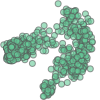

In [59]:
points

In [60]:
bounding_box = box(*points.bounds)
bounding_box = affinity.scale(bounding_box, xfact=1.2, yfact=1.2)

In [61]:
polygons = voronoi_polygons(points)

In [62]:
poly_geoJSON = geopandas.GeoSeries([polygons])

In [63]:
poly_geoJSON

0    GEOMETRYCOLLECTION (POLYGON ((-0.83405 0.86354...
dtype: geometry

In [64]:
!pip install geojson-rewind

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
from geojson_rewind import rewind

poly_geoJSON = rewind(poly_geoJSON.to_json())

In [66]:
with open('voronoi.geojson', 'w') as file:
     file.write(poly_geoJSON)

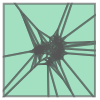

In [67]:
polygons

In [68]:
color_space = (color_space-np.min(color_space))/(np.max(color_space)-np.min(color_space))

In [69]:
hsv_colors = [colorsys.rgb_to_hsv(*color) for color in color_space]
tweaked_colors = [colorsys.hsv_to_rgb(hue, saturation/2, 1-((1-value)/1.25)) for hue,saturation,value in hsv_colors]

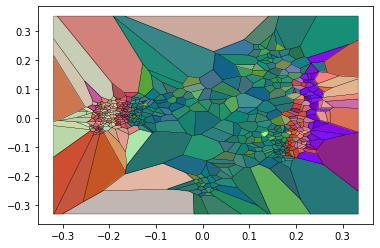

In [80]:
for i, polygon in enumerate(polygons.geoms):
    clipped_polygon = polygon.intersection(bounding_box)
    plt.plot(*clipped_polygon.exterior.xy, c='black', linewidth=0.2)
    plt.fill(*clipped_polygon.exterior.xy, c=color_space[i])
#plt.show()
plt.savefig('voronoi.png')